# Exploratory Data Analysis — Customer Churn

Quick look at the churn dataset stored in DuckDB.

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config import DB_PATH

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 20)

## 1. Load data from DuckDB

In [2]:
con = duckdb.connect(DB_PATH, read_only=True)

df = con.execute("SELECT * FROM churn").fetchdf()
print(f"Rows: {len(df):,}")
df.head()

Rows: 5,000


,age,tenure,monthly_charges,total_charges,gender,contract,payment_method,internet_service,online_security,tech_support,churn
0,54,6,105.30,598.87,Male,Month-to-month,Mailed check,Fiber optic,No,No,1
1,48,24,103.05,2485.58,Female,One year,Bank transfer,DSL,No,Yes,0
2,59,51,93.27,4743.22,Female,Two year,Electronic check,DSL,Yes,Yes,0
3,21,30,41.23,1280.60,Male,One year,Electronic check,None,No,No,0
4,56,12,57.40,671.42,Male,Month-to-month,Mailed check,Fiber optic,Yes,No,1


In [3]:
# quick summary from DuckDB directly
con.execute("SELECT * FROM churn_summary").fetchdf()

,churn,n
0,0,3196
1,1,1804


## 2. Basic statistics

In [4]:
df.describe()

,age,tenure,monthly_charges,total_charges,churn
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,48.599200,35.39620,75.196680,2657.905446,0.360800
std,17.807706,20.80735,24.057757,1843.730677,0.480281
min,18.000000,0.00000,18.000000,0.000000,0.000000
25%,33.000000,17.00000,59.037500,1131.310000,0.000000
50%,48.000000,35.00000,75.995000,2368.290000,0.000000
75%,64.000000,53.00000,91.672500,3967.620000,1.000000
max,79.000000,71.00000,160.000000,10338.640000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               5000 non-null   int64  
 1   tenure            5000 non-null   int64  
 2   monthly_charges   5000 non-null   float64
 3   total_charges     5000 non-null   float64
 4   gender            5000 non-null   object 
 5   contract          5000 non-null   object 
 6   payment_method    5000 non-null   object 
 7   internet_service  5000 non-null   object 
 8   online_security   5000 non-null   object 
 9   tech_support      5000 non-null   object 
 10  churn             5000 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 429.8+ KB


In [6]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
age                 0
tenure              0
monthly_charges     0
total_charges       0
gender              0
contract            0
payment_method      0
internet_service    0
online_security     0
tech_support        0
churn               0
dtype: int64


## 3. Churn distribution

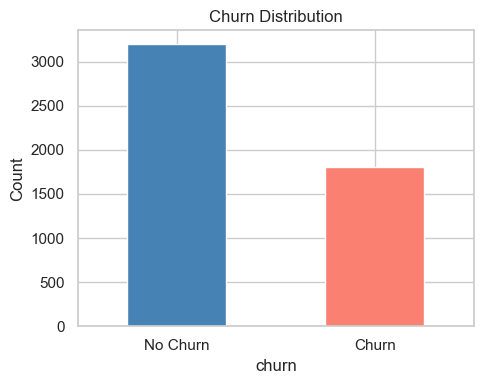

Churn rate: 36.08%


In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
df["churn"].value_counts().plot.bar(ax=ax, color=["steelblue", "salmon"])
ax.set_xticklabels(["No Churn", "Churn"], rotation=0)
ax.set_ylabel("Count")
ax.set_title("Churn Distribution")
plt.tight_layout()
plt.show()

print(f"Churn rate: {df['churn'].mean():.2%}")

## 4. Numeric feature distributions

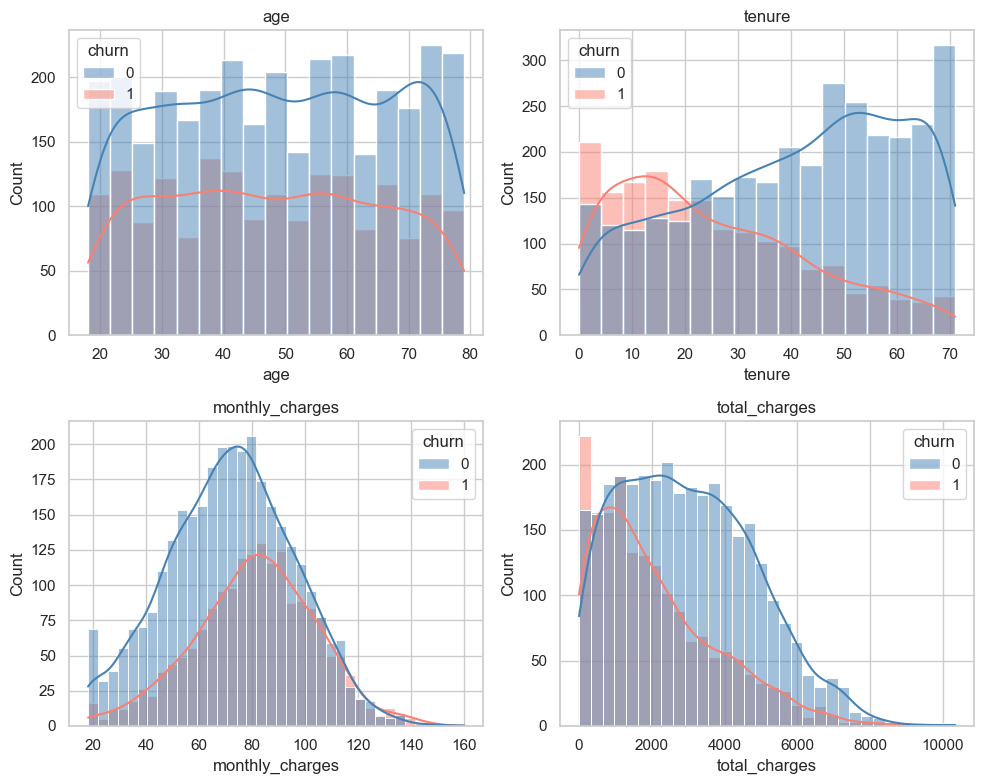

In [8]:
num_cols = ["age", "tenure", "monthly_charges", "total_charges"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(data=df, x=col, hue="churn", kde=True, ax=ax, palette=["steelblue", "salmon"])
    ax.set_title(col)
plt.tight_layout()
plt.show()

## 5. Churn rate by categorical features

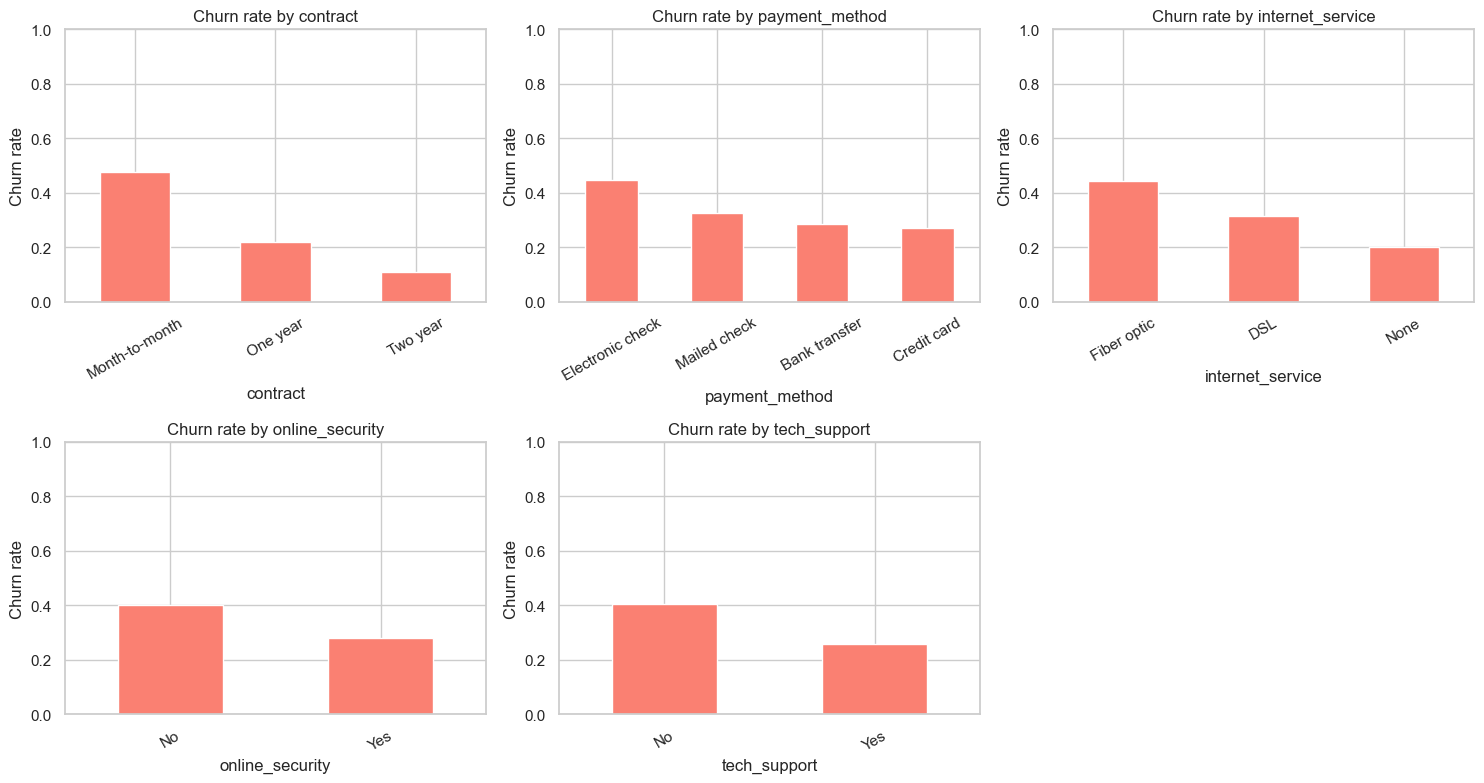

In [9]:
cat_cols = ["contract", "payment_method", "internet_service", "online_security", "tech_support"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, col in zip(axes.flat, cat_cols):
    rates = df.groupby(col)["churn"].mean().sort_values(ascending=False)
    rates.plot.bar(ax=ax, color="salmon")
    ax.set_title(f"Churn rate by {col}")
    ax.set_ylabel("Churn rate")
    ax.set_ylim(0, 1)
    ax.tick_params(axis="x", rotation=30)

# hide extra subplot
axes.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

## 6. Correlation heatmap

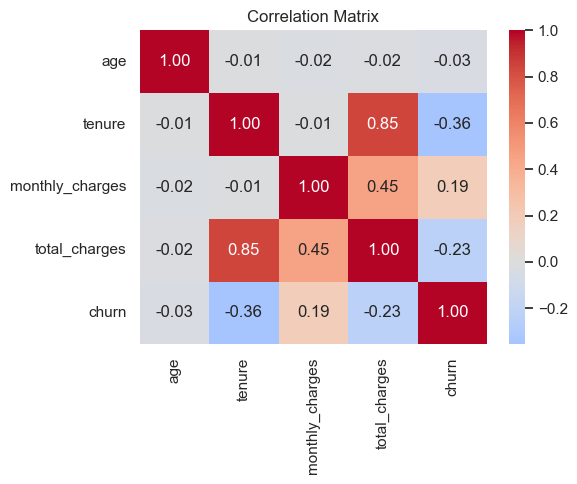

In [10]:
corr = df[num_cols + ["churn"]].corr()

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

## 7. DuckDB aggregation queries

In [11]:
# average metrics by contract type
query = """
SELECT
    contract,
    COUNT(*) AS n,
    ROUND(AVG(churn), 3) AS churn_rate,
    ROUND(AVG(monthly_charges), 2) AS avg_monthly,
    ROUND(AVG(tenure), 1) AS avg_tenure
FROM churn
GROUP BY contract
ORDER BY churn_rate DESC
"""
con.execute(query).fetchdf()

,contract,n,churn_rate,avg_monthly,avg_tenure
0,Month-to-month,3051,0.477,75.81,35.8
1,One year,1237,0.220,74.42,34.1
2,Two year,712,0.110,73.91,35.7


In [12]:
# high-risk segment
query = """
SELECT COUNT(*) AS n, ROUND(AVG(churn), 3) AS churn_rate
FROM churn
WHERE contract = 'Month-to-month'
  AND payment_method = 'Electronic check'
  AND tenure < 12
"""
con.execute(query).fetchdf()

,n,churn_rate
0,219,0.858


In [13]:
con.close()

## Key Takeaways

- Month-to-month contracts have the highest churn rate
- Electronic check users churn more than other payment methods
- Lower tenure strongly correlates with higher churn
- Fiber optic users churn more, likely due to higher charges
- Customers without tech support or online security churn more